#Модели для системы оценивающей объекты недвижимости по их параметрам

На основании предоставленных параметров проекта я выбрал использование алгоритмы градиентного бустинга, такие как XGBoost, CatBoost или LightGBM. Эти алгоритмы имеют хорошую производительность и могут обрабатывать категориальные признаки, что является важным для данного датасета.

В данном файле действем по следующему алгоритму:

1.   Делим датаесет на тестовую и тренировочную выборки
2.   Обучаем выбранные модели
3.   Смотрим на результаты
4.   Сохраняем лучшую модель


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install catboost

In [4]:
import tensorflow as tf
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import folium

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split, GridSearchCV
from lightgbm import LGBMRegressor
from sklearn.model_selection import learning_curve
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error

from sklearn.model_selection import GridSearchCV
from catboost import CatBoostRegressor
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from xgboost import XGBRegressor



# Сброс ограничений на количество выводимых рядов
pd.set_option('display.max_rows', None)
 
# Сброс ограничений на число столбцов
pd.set_option('display.max_columns', None)
 
# Сброс ограничений на количество символов в записи
pd.set_option('display.max_colwidth', None)

In [5]:
data_itog = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/files_labs/E-SOFT/final_data.xlsx')
display(data_itog.info())
display(data_itog.shape)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59667 entries, 0 to 59666
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   sold_price              59667 non-null  int64  
 1   floor_num               59667 non-null  int64  
 2   floors_cnt              59667 non-null  int64  
 3   rooms_cnt               59667 non-null  int64  
 4   bedrooms_cnt            59667 non-null  int64  
 5   building_year           59667 non-null  int64  
 6   area_total              59667 non-null  float64
 7   type                    59667 non-null  int64  
 8   two_levels              59667 non-null  int64  
 9   bathroom                59667 non-null  int64  
 10  bathrooms_cnt           59667 non-null  int64  
 11  windows                 59667 non-null  int64  
 12  territory               59667 non-null  int64  
 13  keep                    59667 non-null  int64  
 14  balcon                  59667 non-null

None

(59667, 22)

In [6]:
display(data_itog.head(10))

,sold_price,floor_num,floors_cnt,rooms_cnt,bedrooms_cnt,building_year,area_total,type,two_levels,bathroom,bathrooms_cnt,windows,territory,keep,balcon,city_district_id,city_street_id,building_year_category,sold_price_category,wall_id_category,series_id_category,area_total_category
0,4880000,5,9,3,0,1989,62.0,0,0,0,1,0,3,0,0,0,0,2,8,0,1,6
1,2550000,5,10,1,0,2008,40.0,0,0,1,1,1,4,1,0,1,1,3,4,1,1,3
2,2200000,5,5,2,0,1969,44.0,0,0,1,1,0,3,0,0,2,2,1,3,1,1,4
3,2200000,4,5,2,0,1988,47.3,0,0,0,1,0,3,0,3,4,4,2,3,1,1,4
4,2000000,3,9,1,1,1980,33.0,0,0,1,2,0,3,0,0,7,7,1,2,1,1,3
5,4300000,2,10,1,0,2006,52.0,0,0,0,1,0,6,0,3,7,8,3,7,0,0,5
6,3450000,9,10,2,1,2009,55.0,0,0,1,1,0,3,0,3,8,9,3,5,0,0,5
7,9600000,14,14,3,0,2005,114.0,0,0,1,2,0,6,4,0,9,10,3,18,0,0,11
8,3100000,1,5,3,0,1994,61.0,0,0,1,1,0,3,0,0,10,11,2,5,0,1,6
9,3500000,5,9,3,0,1990,77.0,0,0,1,1,0,3,0,1,11,12,2,5,2,2,7


In [7]:
# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(data_itog.drop('sold_price', axis=1), 
                                                    data_itog['sold_price'], 
                                                    test_size=0.3, 
                                                    random_state=42)


#LightGBM

In [8]:
# Определение модели LightGBM
model = LGBMRegressor()

In [9]:
# Определение сетки гиперпараметров для поиска оптимальных значений
param_grid = {
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7]
}

# Создание объекта GridSearchCV для подбора оптимальных гиперпараметров
grid = GridSearchCV(model, param_grid, cv=5)

# Обучение модели на тренировочной выборке
grid.fit(X_train, y_train)


GridSearchCV(cv=5, estimator=LGBMRegressor(),
             param_grid={'learning_rate': [0.1, 0.01, 0.001],
                         'max_depth': [3, 5, 7],
                         'n_estimators': [50, 100, 200]})

# Вывод наилучших параметров и результатов модели LightGBM

In [10]:

print("Best parameters: ", grid.best_params_)
print("Train score: {:.4f}".format(grid.score(X_train, y_train)))
print("Test score: {:.4f}".format(grid.score(X_test, y_test)))

Best parameters:  {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200}
Train score: 0.9881
Test score: 0.9869


In [11]:
y_train_pred = grid.predict(X_train)
y_test_pred = grid.predict(X_test)

train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

y_pred_train = grid.predict(X_train)
y_pred_test = grid.predict(X_test)

train_mse = mean_squared_error(y_train, y_pred_train)
test_mse = mean_squared_error(y_test, y_pred_test)

In [12]:
print("Best parameters: ", grid.best_params_)
print("Train score: {:.4f}".format(grid.score(X_train, y_train)))
print("Test score: {:.4f}".format(grid.score(X_test, y_test)))
print("Train RMSE: {:.4f}".format(np.sqrt(mean_squared_error(y_train, y_train_pred))))
print("Test RMSE: {:.4f}".format(np.sqrt(mean_squared_error(y_test, y_test_pred))))
print("Train R^2: {:.4f}".format(r2_score(y_train, y_train_pred)))
print("Test R^2: {:.4f}".format(r2_score(y_test, y_test_pred)))
print("Train MAE: {:.4f}".format(train_mae))
print("Test MAE: {:.4f}".format(test_mae))

y_pred_train = grid.predict(X_train)
y_pred_test = grid.predict(X_test)

train_mse = mean_squared_error(y_train, y_pred_train)
test_mse = mean_squared_error(y_test, y_pred_test)

Best parameters:  {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200}
Train score: 0.9881
Test score: 0.9869
Train RMSE: 128659.0546
Test RMSE: 135886.9488
Train R^2: 0.9881
Test R^2: 0.9869
Train MAE: 109076.6006
Test MAE: 115301.8229


Кросс валидация 

In [13]:

# Здесь проводим кросс-валидацию с 5 фолдами и считаем метрику на каждом фолде
scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')

# Здесь выводим среднее значение и стандартное отклонение метрики
print("Mean R^2 score: {:.4f} (std: {:.4f})".format(np.mean(scores), np.std(scores)))


Mean R^2 score: 0.9863 (std: 0.0004)


Кривые обучения и валидации

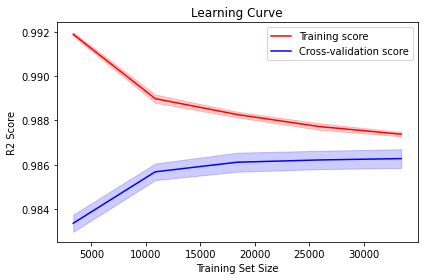

In [14]:
train_sizes, train_scores, test_scores = learning_curve(
    model, X_train, y_train, cv=5, scoring='r2', n_jobs=-1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean, label="Training score", color="r")
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="r", alpha=0.2)
plt.plot(train_sizes, test_mean, label="Cross-validation score", color="b")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="b", alpha=0.2)

plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("R2 Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()


#CatBoostRegressor

In [ ]:

# инициализация модели CatBoostRegressor
cat_model = CatBoostRegressor()

# задаем сетку гиперпараметров для перебора
parameters = {
    'iterations': [100, 500, 1000],
    'learning_rate': [0.01, 0.1, 0.5],
    'depth': [4, 6, 8],
    'l2_leaf_reg': [1, 3, 5]
}

# создаем объект для поиска по сетке с кросс-валидацией
grid_search = GridSearchCV(estimator=cat_model, 
                           param_grid=parameters, 
                           cv=3, 
                           n_jobs=-1, 
                           verbose=3)

# запускаем перебор гиперпараметров на обучающей выборке
grid_search.fit(X_train, y_train)

# выводим наилучшие гиперпараметры и значение метрики качества
print("Best score: %f using %s" % (grid_search.best_score_, grid_search.best_params_))

**Закомментируем код выше чтобы каждый раз не вычислять оптимальные гиперпараметры** 

In [16]:
# Best score: 0.986447 using {'depth': 6, 'iterations': 1000, 'l2_leaf_reg': 1, 'learning_rate': 0.1}

In [ ]:
# создаем модель с наилучшими параметрами и обучаем ее на всей обучающей выборке
best_model = CatBoostRegressor(**grid_search.best_params_)
best_model.fit(X_train, y_train)

# оцениваем качество модели на тестовой выборке
# RMSE: 134973.88
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print("RMSE: %.2f" % (rmse))

In [18]:
importance = best_model.get_feature_importance()
print(importance)
print(len(importance))

[1.21229025e-01 1.69430372e-01 1.18285133e-01 5.49012523e-02
 2.34800501e-01 6.69294618e-01 5.45691457e-02 4.67615362e-04
 2.50772234e-02 1.10277696e-01 3.39094012e-02 9.48218910e-02
 1.45342623e-01 7.83052869e-02 5.69538018e-01 3.76823572e-01
 1.98602197e-02 9.69242798e+01 7.63496047e-02 7.43400787e-02
 4.80969489e-02]
21


In [19]:
print("Train score: {:.4f}".format(best_model.score(X_train, y_train)))
print("Test score: {:.4f}".format(best_model.score(X_test, y_test)))

Train score: 0.9893
Test score: 0.9871


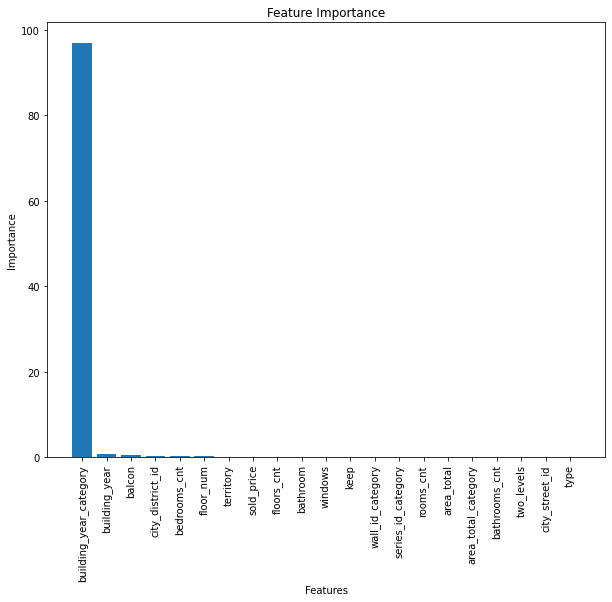

In [21]:
# Названия признаков
features = ['sold_price', 'floor_num', 'floors_cnt', 'rooms_cnt', 'bedrooms_cnt',
            'building_year', 'area_total', 'type', 'two_levels', 'bathroom', 'bathrooms_cnt',
            'windows', 'territory', 'keep', 'balcon', 'city_district_id', 'city_street_id',
            'building_year_category', 'wall_id_category', 'series_id_category',
            'area_total_category']

# Важность признаков
importance = [1.21229025e-01, 1.69430372e-01, 1.18285133e-01, 5.49012523e-02,
              2.34800501e-01, 6.69294618e-01, 5.45691457e-02, 4.67615362e-04,
              2.50772234e-02, 1.10277696e-01, 3.39094012e-02, 9.48218910e-02,
              1.45342623e-01, 7.83052869e-02, 5.69538018e-01, 3.76823572e-01,
              1.98602197e-02, 9.69242798e+01, 7.63496047e-02, 7.43400787e-02,
              4.80969489e-02]

# Создаем словарь из названий признаков и их важности
feature_importance_dict = dict(zip(features, importance))

# Сортируем словарь по убыванию важности признаков
sorted_feature_importance_dict = dict(sorted(feature_importance_dict.items(), 
                                             key=lambda x: x[1], reverse=True))

# Создаем список с названиями признаков, отсортированный по убыванию важности
sorted_feature_names = list(sorted_feature_importance_dict.keys())

# Создаем список с важностью признаков, отсортированный по убыванию
sorted_importance = list(sorted_feature_importance_dict.values())

# Создаем график важности признаков
plt.figure(figsize=(10, 8))
plt.bar(sorted_feature_names, sorted_importance)
plt.xticks(rotation=90)
plt.title('Feature Importance')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()

In [22]:
# make predictions on train set
y_train_pred = best_model.predict(X_train)

# make predictions on test set
y_test_pred = best_model.predict(X_test)

train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

y_pred_train = best_model.predict(X_train)
y_pred_test = best_model.predict(X_test)

train_mse = mean_squared_error(y_train, y_pred_train)
test_mse = mean_squared_error(y_test, y_pred_test)

# Вывод наилучших параметров и результатов модели CatBoostRegressor

In [23]:
# print("Best parameters: ", best_model.best_params_)
print("Train score: {:.4f}".format(best_model.score(X_train, y_train)))
print("Test score: {:.4f}".format(best_model.score(X_test, y_test)))
print("Train RMSE: {:.4f}".format(np.sqrt(mean_squared_error(y_train, y_train_pred))))
print("Test RMSE: {:.4f}".format(np.sqrt(mean_squared_error(y_test, y_test_pred))))
print("Train R^2: {:.4f}".format(r2_score(y_train, y_train_pred)))
print("Test R^2: {:.4f}".format(r2_score(y_test, y_test_pred)))
print("Train MAE: {:.4f}".format(train_mae))
print("Test MAE: {:.4f}".format(test_mae))

y_pred_train = best_model.predict(X_train)
y_pred_test = best_model.predict(X_test)

train_mse = mean_squared_error(y_train, y_pred_train)
test_mse = mean_squared_error(y_test, y_pred_test)

Train score: 0.9893
Test score: 0.9871
Train RMSE: 121707.5897
Test RMSE: 134973.8830
Train R^2: 0.9893
Test R^2: 0.9871
Train MAE: 102425.6390
Test MAE: 113865.2840


In [ ]:
# Здесь проводим кросс-валидацию с 5 фолдами и считаем метрику на каждом фолде
scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring='r2')

# Здесь выводим среднее значение и стандартное отклонение метрики
print("Mean R^2 score: {:.4f} (std: {:.4f})".format(np.mean(scores), np.std(scores)))


In [ ]:
# Mean R^2 score: 0.9866 (std: 0.0004)

Кривые обучения и валидации

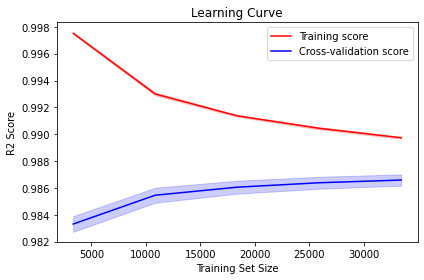

In [25]:
train_sizes, train_scores, test_scores = learning_curve(
    best_model, X_train, y_train, cv=5, scoring='r2', n_jobs=-1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean, label="Training score", color="r")
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="r", alpha=0.2)
plt.plot(train_sizes, test_mean, label="Cross-validation score", color="b")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="b", alpha=0.2)

plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("R2 Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

#XGBoost

In [26]:
# Создание модели XGBoost
# model_XGB = XGBRegressor()

# # Создание сетки параметров для перебора
# param_grid = {
#         'learning_rate': [0.01, 0.1, 0.5, 1],
#         'max_depth': [3, 5, 7, 9],
#         'n_estimators': [50, 100, 200, 500],
#         'subsample': [0.5, 0.7, 1.0],
#         'colsample_bytree': [0.5, 0.7, 1.0],
#         'gamma': [0, 0.1, 0.5, 1]
# }

# # Создание объекта RandomizedSearchCV для поиска по сетке
# random_search = RandomizedSearchCV(model_XGB, param_distributions=param_grid, n_iter=50, cv=5, verbose=2, random_state=42, n_jobs=-1)

# # Обучение модели с поиском по сетке
# random_search.fit(X_train, y_train)

# # Вывод лучших параметров модели
# print(random_search.best_params_)

In [27]:
# Лушчие гиперпараметры из кода выше (считается ~40 мин)
# {'subsample': 1.0, 'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.5, 'gamma': 0, 'colsample_bytree': 1.0}

In [28]:
# Инициализация модели XGBoostRegressor
xgb_model = XGBRegressor(objective='reg:squarederror', 
                          eval_metric='rmse', 
                          subsample=1.0, 
                          n_estimators=200, 
                          max_depth=3, 
                          learning_rate=0.5, 
                          gamma=0, 
                          colsample_bytree=1.0)

# Обучение модели
xgb_model.fit(X_train, y_train)

# Предсказание на тестовой выборке
y_pred = xgb_model.predict(X_test)

# Оценка качества модели
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print("RMSE: %.2f" % (rmse))


RMSE: 136420.99


In [29]:
importance = xgb_model.feature_importances_
print(importance)

[2.3084143e-04 4.5987443e-04 2.7047374e-04 2.1746328e-04 2.7466446e-04
 8.3553354e-04 2.7807482e-04 3.4487446e-05 2.2582020e-04 4.2171052e-04
 3.9714988e-04 2.7451944e-04 4.5272397e-04 2.3244441e-04 4.9889274e-04
 3.8653542e-04 0.0000000e+00 9.9373800e-01 3.7894532e-04 3.9183261e-04
 0.0000000e+00]


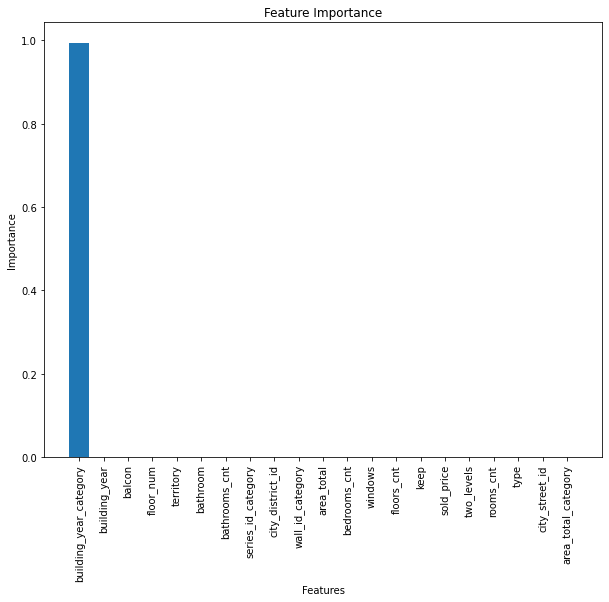

In [30]:
# Задаем названия признаков
feature_names = ['sold_price', 'floor_num', 'floors_cnt', 'rooms_cnt', 'bedrooms_cnt',
                 'building_year', 'area_total', 'type', 'two_levels', 'bathroom', 
                 'bathrooms_cnt', 'windows', 'territory', 'keep', 'balcon',
                 'city_district_id', 'city_street_id', 'building_year_category', 
                 'wall_id_category', 'series_id_category', 'area_total_category']

# Задаем важность признаков, полученную из модели
importance = [2.3084143e-04, 4.5987443e-04, 2.7047374e-04, 2.1746328e-04, 
              2.7466446e-04, 8.3553354e-04, 2.7807482e-04, 3.4487446e-05,
              2.2582020e-04, 4.2171052e-04, 3.9714988e-04, 2.7451944e-04,
              4.5272397e-04, 2.3244441e-04, 4.9889274e-04, 3.8653542e-04,
              0.0000000e+00, 9.9373800e-01, 3.7894532e-04, 3.9183261e-04,
              0.0000000e+00]

# Создаем словарь из названий признаков и их важности
feature_importance_dict = dict(zip(feature_names, importance))

# Сортируем словарь по убыванию важности признаков
sorted_feature_importance_dict = dict(sorted(feature_importance_dict.items(), 
                                             key=lambda x: x[1], reverse=True))

# Создаем список с названиями признаков, отсортированный по убыванию важности
sorted_feature_names = list(sorted_feature_importance_dict.keys())

# Создаем список с важностью признаков, отсортированный по убыванию
sorted_importance = list(sorted_feature_importance_dict.values())

# Создаем график важности признаков
plt.figure(figsize=(10, 8))
plt.bar(sorted_feature_names, sorted_importance)
plt.xticks(rotation=90)
plt.title('Feature Importance')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()

In [31]:
# make predictions on train set
y_train_pred = xgb_model.predict(X_train)

# make predictions on test set
y_test_pred = xgb_model.predict(X_test)

train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

y_pred_train = xgb_model.predict(X_train)
y_pred_test = xgb_model.predict(X_test)

train_mse = mean_squared_error(y_train, y_pred_train)
test_mse = mean_squared_error(y_test, y_pred_test)

# Вывод наилучших параметров и результатов модели XGBoost

In [32]:
# print("Best parameters: ", xgb_model.best_params_)
print("Train score: {:.4f}".format(xgb_model.score(X_train, y_train)))
print("Test score: {:.4f}".format(xgb_model.score(X_test, y_test)))
print("Train RMSE: {:.4f}".format(np.sqrt(mean_squared_error(y_train, y_train_pred))))
print("Test RMSE: {:.4f}".format(np.sqrt(mean_squared_error(y_test, y_test_pred))))
print("Train R^2: {:.4f}".format(r2_score(y_train, y_train_pred)))
print("Test R^2: {:.4f}".format(r2_score(y_test, y_test_pred)))
print("Train MAE: {:.4f}".format(train_mae))
print("Test MAE: {:.4f}".format(test_mae))

y_pred_train = xgb_model.predict(X_train)
y_pred_test = xgb_model.predict(X_test)

train_mse = mean_squared_error(y_train, y_pred_train)
test_mse = mean_squared_error(y_test, y_pred_test)

Train score: 0.9878
Test score: 0.9868
Train RMSE: 130236.3975
Test RMSE: 136420.9858
Train R^2: 0.9878
Test R^2: 0.9868
Train MAE: 110141.3504
Test MAE: 115266.2338


In [33]:
# Здесь проводим кросс-валидацию с 5 фолдами и считаем метрику на каждом фолде
scores = cross_val_score(xgb_model, X_train, y_train, cv=5, scoring='r2')

# Здесь выводим среднее значение и стандартное отклонение метрики
print("Mean R^2 score: {:.4f} (std: {:.4f})".format(np.mean(scores), np.std(scores)))

Mean R^2 score: 0.9863 (std: 0.0004)


Кривые обучения и валидации

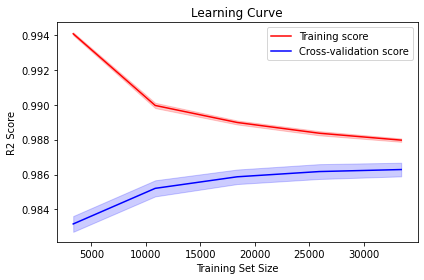

In [34]:
train_sizes, train_scores, test_scores = learning_curve(
    xgb_model, X_train, y_train, cv=5, scoring='r2', n_jobs=-1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean, label="Training score", color="r")
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="r", alpha=0.2)
plt.plot(train_sizes, test_mean, label="Cross-validation score", color="b")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="b", alpha=0.2)

plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("R2 Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

Вывод: 

Проанализировав 3 модели лучшей оказалась **CatBoostRegressor** ввиду того что она обладает наиболее благоприятными параметрами, сохраним эту модель и сделаем систему оценивающую объекты недвижимости по их параметрам

In [ ]:
import catboost as cb

best_model = cb.CatBoostRegressor()
best_model.fit(X_train, y_train)

best_model.save_model('/content/drive/MyDrive/Colab Notebooks/files_labs/E-SOFT/catboost_model.dump')
